In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tensorflow
import tqdm
import glob

# Importing specific functions and classes from libraries
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

%matplotlib inline# For displaying plots inline in Jupyter Notebooks

In [3]:
# Loading and counting images from 'Organic' and 'Recycle' folders
train_o = glob.glob("D:/Sandy/Projects/Waste Management Classification/TRAIN/O/*.jpg")
a = len(train_o)

train_r = glob.glob("D:/Sandy/Projects/Waste Management Classification/TRAIN/R/*.jpg")
b = len(train_r)

In [5]:
print("Nos of training samples: {}".format(a+b))

Nos of training samples: 22574


In [6]:
# Defining ImageDataGenerators for data augmentation and validation splitting
train_datagenerator = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagenerator = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagenearator = ImageDataGenerator(rescale = 1.0 / 255.0)

In [8]:
# Loading and splitting training and validation datasets
train_dataset  = train_datagenerator.flow_from_directory(directory = 'D:/Sandy/Projects/Waste Management Classification/TRAIN/',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128,
                                                   subset = 'training')

Found 18060 images belonging to 2 classes.


In [10]:
valid_dataset = valid_datagenerator.flow_from_directory(directory = 'D:/Sandy/Projects/Waste Management Classification/TRAIN/',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128,
                                                  subset = 'validation')

Found 4514 images belonging to 2 classes.


In [11]:
train_dataset.class_indices

{'O': 0, 'R': 1}

100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


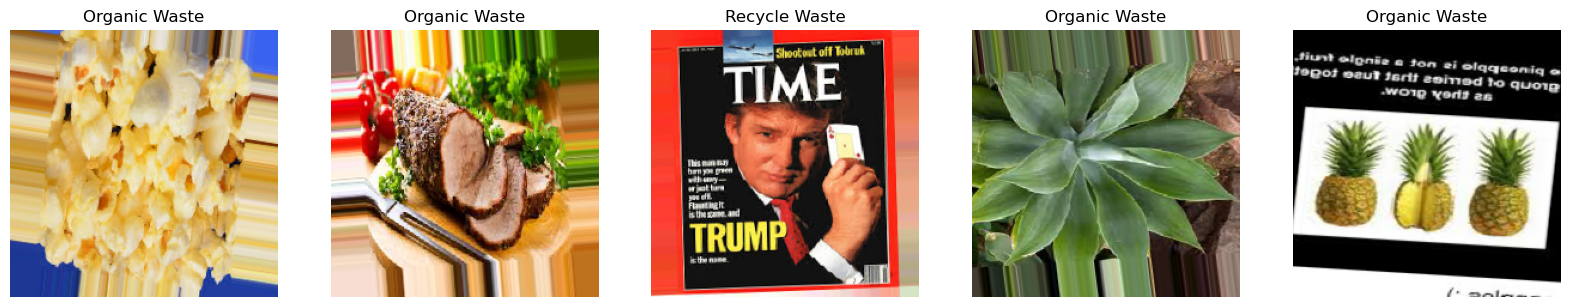

In [12]:
# Displaying some sample images with labels
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(128)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    label = train_dataset[rand1][1][rand2]
    if label == 1:
        ax[i].set_title('Recycle Waste')
    else:
        ax[i].set_title('Organic Waste')

In [13]:
# Loading VGG16 pre-trained model and freezing its layers
base_model = VGG16(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [14]:
for layer in base_model.layers:
    layer.trainable=False

In [15]:
base_model.summary() # Display model architecture


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
# Building custom model on top of VGG16 base
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [17]:
model.summary() # Display final model structure

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,564,993 (158.56 MB)

 Trainable params: 26,796,033 (102.22 MB)

 Non-trainable params: 14,768,960 (56.34 MB)

In [19]:
# Defining optimizer, loss function, and metrics
OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [22]:
# Model checkpoint and early stopping for training
filepath = './best_weights.keras'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [24]:
# Training the model with callback settings
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 5,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - auc: 0.9472 - loss: 0.2960 
Epoch 1: val_auc improved from -inf to 0.94383, saving model to ./best_weights.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 4728s 34s/step - auc: 0.9473 - loss: 0.2959 - val_auc: 0.9438 - val_loss: 0.3158
Epoch 2/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - auc: 0.9588 - loss: 0.2579 
Epoch 2: val_auc improved from 0.94383 to 0.95378, saving model to ./best_weights.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 4693s 33s/step - auc: 0.9588 - loss: 0.2578 - val_auc: 0.9538 - val_loss: 0.2753
Epoch 3/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - auc: 0.9681 - loss: 0.2258 
Epoch 3: val_auc did not improve from 0.95378
142/142 ━━━━━━━━━━━━━━━━━━━━ 5086s 36s/step - auc: 0.9681 - loss: 0.2258 - val_auc: 0.9521 - val_loss: 0.2815
Epoch 4/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - auc: 0.9706 - loss: 0.2166 
Epoch 4: val_auc did not improve from 0.95378
142/142 ━━━━━━━━━━━━━━━━━━━━ 2853s 20s/step - auc: 0.9706 - loss: 0.2166 - val_au

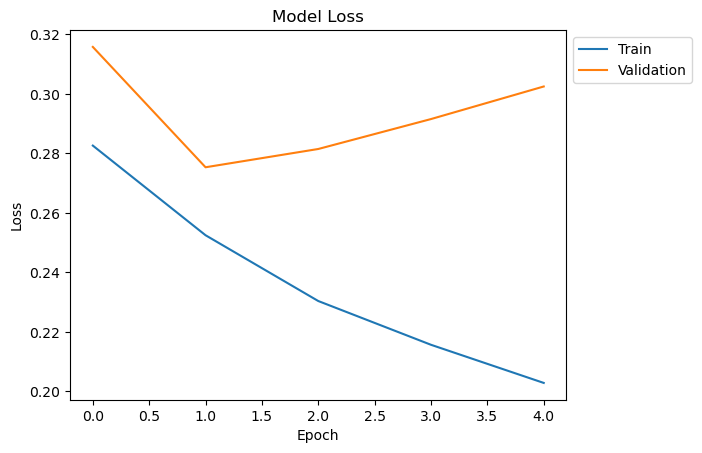

In [25]:
# Plotting training and validation loss over epochs
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

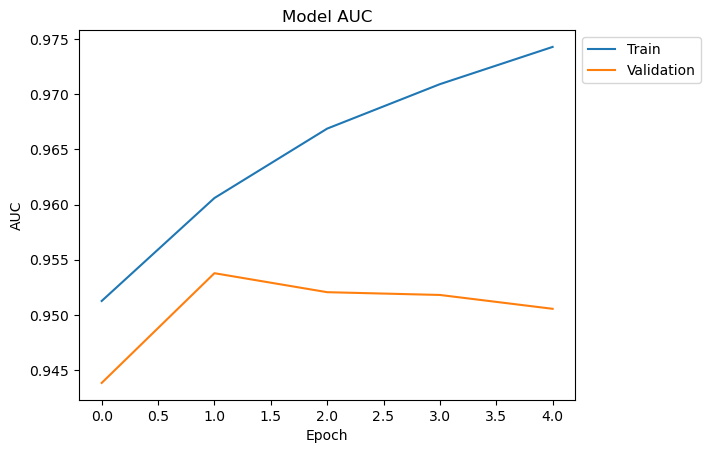

In [26]:
# Plotting training and validation AUC over epochs
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [30]:
# Loading test data
test_data = test_datagenearator.flow_from_directory(directory = "D:/Sandy/Projects/Waste Management Classification/TEST",
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 128)

Found 2513 images belonging to 2 classes.


In [31]:
# Evaluating Loss and AUC - Test Data
model.evaluate(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 282s 14s/step - auc: 0.9429 - loss: 0.3691


[0.3421463668346405, 0.9481171369552612]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


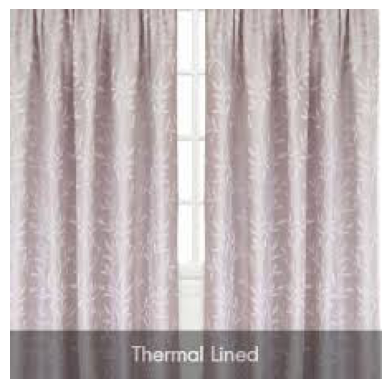

The image belongs to Organic waste category


In [48]:
# Image selection and classification functions for prediction
from tkinter import Tk, filedialog

# Function to choose an image file
def choose_image_from_folder():
    root = Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(
        initialdir='D:/Sandy/Projects/Waste Management Classification/TEST',
        title="Select an image file", 
        filetypes=[("Image files", "*.jpg;*.jpeg;*.png")]
    )
    root.destroy()  # Close the main window
    return file_path

# Model Prediction Function
def classify_image(selected_img):
    img = load_img(selected_img, target_size=(224, 224))
    img = img_to_array(img) / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Expand dimensions for model input

    # Make predictions
    answer = model.predict(img)

    # Displaying image and prediction result
    plt.imshow(load_img(selected_img))
    plt.axis('off')
    plt.show()
    
    if answer[0][0] > 0.5:
        print("The image belongs to Recycle waste category")
    else:
        print("The image belongs to Organic waste category")

# Select and classify an image
selected_img = choose_image_from_folder()
if selected_img:  # Check if an image was selected
    classify_image(selected_img)
else:
    print("No image selected.")


In [54]:
#Load the model (ensure your model file path is correct)
model.save('wasteidentify.h5')